## generate ellipse complex

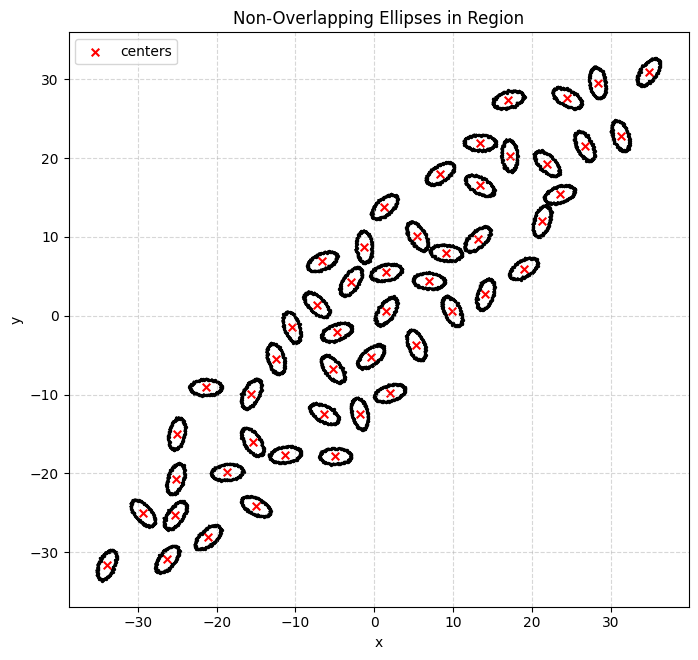

In [14]:
import numpy as np
import math
import matplotlib.pyplot as plt

def rotate_points_about_center(points, center, angle):
    """
    Rotate an array of points about a specified center by 'angle' radians.
    """
    translated = points - center
    cosθ = math.cos(angle)
    sinθ = math.sin(angle)
    R = np.array([[cosθ, -sinθ], [sinθ, cosθ]])
    return translated.dot(R.T) + center

def generate_noisy_ellipse(a, b, center, n_points, noise_std=0.0, seed=None):
    """
    Generates one ellipse with semi-axes (a, b) at 'center', discretized into n_points,
    randomly rotated, with optional Gaussian noise.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # parametric ellipse
    thetas = np.linspace(0, 2*math.pi, n_points, endpoint=False)
    xs = a * np.cos(thetas)
    ys = b * np.sin(thetas)
    base_pts = np.vstack([xs, ys]).T + np.array(center)
    
    # simplices (0- and 1-simplices)
    simplices = []
    for i in range(n_points):
        simplices.append([i])
        simplices.append([i, (i+1) % n_points])
    
    # apply random rotation
    angle = np.random.uniform(0, 2*math.pi)
    pts = rotate_points_about_center(base_pts, np.array(center), angle)
    
    # add noise
    if noise_std > 0:
        pts += np.random.normal(scale=noise_std, size=pts.shape)
    
    return pts, simplices

def sample_centers_nonoverlap(region_a, region_b, region_angle,
                              n_centers, min_dist, seed=None, max_trials=10000):
    """
    Uniformly sample up to n_centers points from an ellipse region
    of semi-axes (region_a, region_b) rotated by region_angle, ensuring
    that any two centers are at least min_dist apart (bounding circles).
    """
    if seed is not None:
        np.random.seed(seed)
    
    centers = []
    trials = 0
    cosθ = math.cos(region_angle)
    sinθ = math.sin(region_angle)
    
    while len(centers) < n_centers and trials < max_trials:
        # sample in unit circle via sqrt+uniform, scale to ellipse
        r = math.sqrt(np.random.rand())
        theta = np.random.rand() * 2 * math.pi
        x = r * math.cos(theta) * region_a
        y = r * math.sin(theta) * region_b
        # rotate to align region
        xr = x * cosθ - y * sinθ
        yr = x * sinθ + y * cosθ
        
        # check non-overlap
        if all(math.hypot(xr - cx, yr - cy) >= min_dist for cx, cy in centers):
            centers.append((xr, yr))
        trials += 1
    
    if len(centers) < n_centers:
        raise RuntimeError(f"Could only place {len(centers)} out of {n_centers} non-overlapping centers.")
    
    return np.array(centers)

def generate_nonoverlapping_ellipses(a, b,
                                     region_a, region_b, region_angle,
                                     n_ellipses, n_points,
                                     noise_std=0.0, seed=None):
    """
    Sample non-overlapping ellipse centers, then generate & merge ellipses
    into one simplicial complex.
    """
    # minimum center separation to avoid overlap (bounding-circles)
    min_dist = 2 * max(a, b)
    centers = sample_centers_nonoverlap(region_a, region_b, region_angle,
                                        n_ellipses, min_dist,
                                        seed=seed)
    
    all_pts = []
    all_sims = []
    offset = 0
    for i, ctr in enumerate(centers):
        pts, sims = generate_noisy_ellipse(a, b, ctr, n_points, noise_std, 
                                           None if seed is None else seed + i)
        all_pts.append(pts)
        # shift indices
        for s in sims:
            all_sims.append([idx + offset for idx in s])
        offset += pts.shape[0]
    
    return np.vstack(all_pts), all_sims, centers

def plot_combined_ellipses(points, simplices, centers=None, title='Non-Overlapping Ellipses'):
    fig, ax = plt.subplots(figsize=(8,8))
    for s in simplices:
        if len(s) == 2:
            pts = points[s]
            ax.plot(pts[:,0], pts[:,1], 'k-')
    ax.scatter(points[:,0], points[:,1], s=2, color='black')
    if centers is not None:
        ax.scatter(centers[:,0], centers[:,1], s=30, marker='x', color='red', label='centers')
        ax.legend()
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Example usage:
a, b = 2.0, 1.0
region_a, region_b = 50.0, 10.0
region_angle = math.pi/4
n_ellipses = 50
n_points = 80
noise_std = 0.05
seed = 42

pts1, sims1, centers1 = generate_nonoverlapping_ellipses(
    a, b,
    region_a, region_b, region_angle,
    n_ellipses, n_points,
    noise_std, seed
)
plot_combined_ellipses(pts1, sims1, centers1, title='Non-Overlapping Ellipses in Region')


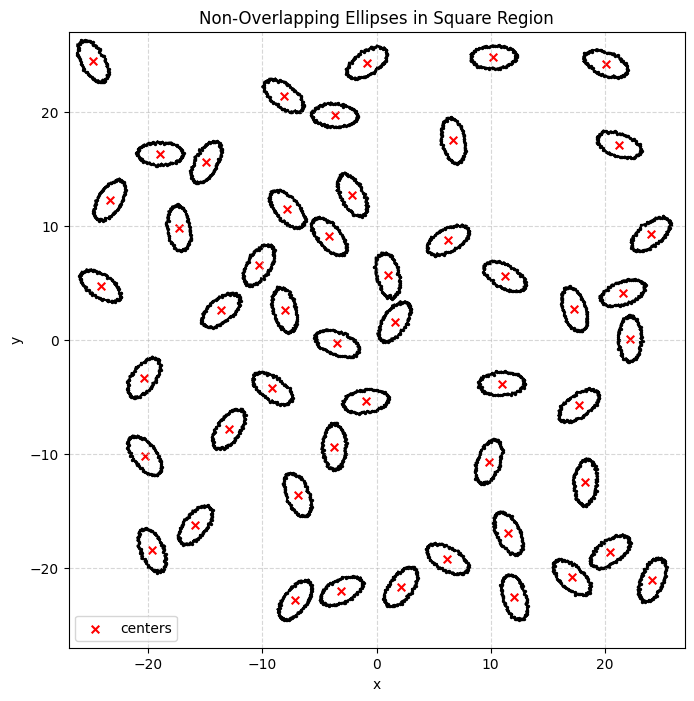

In [15]:
import numpy as np
import math
import matplotlib.pyplot as plt

def rotate_points_about_center(points, center, angle):
    """
    Rotate an array of points about a specified center by 'angle' radians.
    """
    translated = points - center
    cosθ = math.cos(angle)
    sinθ = math.sin(angle)
    R = np.array([[cosθ, -sinθ], [sinθ, cosθ]])
    return translated.dot(R.T) + center

def generate_noisy_ellipse(a, b, center, n_points, noise_std=0.0, seed=None):
    """
    Generates one ellipse with semi-axes (a, b) at 'center', discretized into n_points,
    randomly rotated, with optional Gaussian noise.
    """
    if seed is not None:
        np.random.seed(seed)
    
    thetas = np.linspace(0, 2*math.pi, n_points, endpoint=False)
    xs = a * np.cos(thetas)
    ys = b * np.sin(thetas)
    base_pts = np.vstack([xs, ys]).T + np.array(center)
    
    # build simplices
    simplices = []
    for i in range(n_points):
        simplices.append([i])
        simplices.append([i, (i+1) % n_points])
    
    # random rotation
    angle = np.random.uniform(0, 2*math.pi)
    pts = rotate_points_about_center(base_pts, np.array(center), angle)
    
    # add noise
    if noise_std > 0:
        pts += np.random.normal(scale=noise_std, size=pts.shape)
    
    return pts, simplices

def sample_centers_square(side_length, n_centers, min_dist, seed=None, max_trials=10000):
    """
    Sample up to n_centers from a square region [-side/2, side/2]^2,
    enforcing a minimum distance between any two centers.
    """
    if seed is not None:
        np.random.seed(seed)
    
    half = side_length / 2.0
    centers = []
    trials = 0
    
    while len(centers) < n_centers and trials < max_trials:
        x = np.random.uniform(-half, half)
        y = np.random.uniform(-half, half)
        if all(math.hypot(x - cx, y - cy) >= min_dist for cx, cy in centers):
            centers.append((x, y))
        trials += 1
    
    if len(centers) < n_centers:
        raise RuntimeError(f"Could only place {len(centers)} out of {n_centers} centers.")
    
    return np.array(centers)

def generate_nonoverlapping_ellipses_square(
    a, b, side_length,
    n_ellipses, n_points,
    noise_std=0.0, seed=None
):
    """
    Sample non-overlapping ellipse centers from a square region,
    then generate & merge ellipses into one simplicial complex.
    """
    min_dist = 2 * max(a, b)
    centers = sample_centers_square(side_length, n_ellipses, min_dist, seed)
    
    all_pts = []
    all_sims = []
    offset = 0
    for i, ctr in enumerate(centers):
        pts, sims = generate_noisy_ellipse(a, b, ctr, n_points, noise_std, 
                                           None if seed is None else seed + i)
        all_pts.append(pts)
        for s in sims:
            all_sims.append([idx + offset for idx in s])
        offset += pts.shape[0]
    
    return np.vstack(all_pts), all_sims, centers

def plot_combined_ellipses(points, simplices, centers=None, title='Ellipses in Square Region'):
    """
    Plot the combined ellipses and optionally mark centers.
    """
    fig, ax = plt.subplots(figsize=(8,8))
    for s in simplices:
        if len(s) == 2:
            pts = points[s]
            ax.plot(pts[:,0], pts[:,1], 'k-')
    ax.scatter(points[:,0], points[:,1], s=2, color='black')
    if centers is not None:
        ax.scatter(centers[:,0], centers[:,1], s=30, marker='x', color='red', label='centers')
        ax.legend()
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    ax.set_xlim(-side_length/2 - a, side_length/2 + a)
    ax.set_ylim(-side_length/2 - a, side_length/2 + a)
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Example usage:
a, b = 2.0, 1.0
side_length = 50.0
n_ellipses = 50
n_points = 80
noise_std = 0.05
seed = 123

pts2, sims2, centers2 = generate_nonoverlapping_ellipses_square(
    a, b, side_length,
    n_ellipses, n_points,
    noise_std, seed
)
plot_combined_ellipses(pts2, sims2, centers2, title='Non-Overlapping Ellipses in Square Region')


## filled in

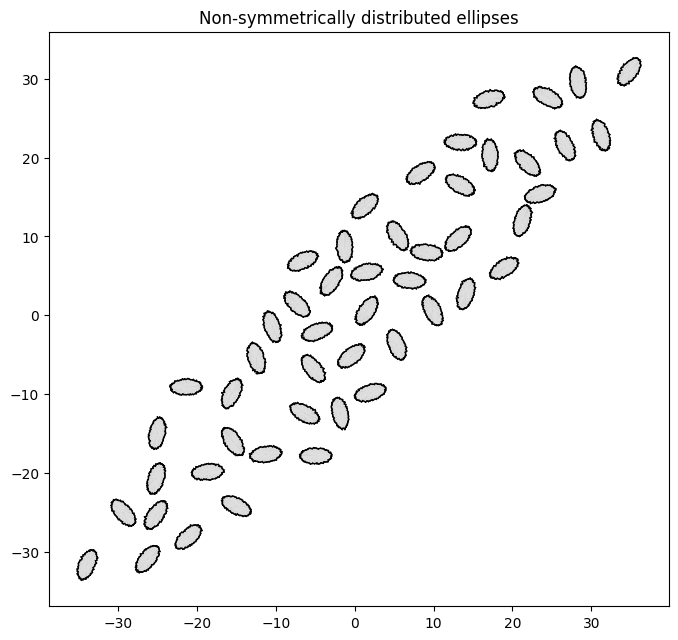

In [28]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

def rotate_points_about_center(points, center, angle):
    """
    Rotate an array of points about a specified center by 'angle' radians.
    """
    translated = points - center
    cosθ = math.cos(angle)
    sinθ = math.sin(angle)
    R = np.array([[cosθ, -sinθ], [sinθ, cosθ]])
    return translated.dot(R.T) + center

def generate_noisy_filled_ellipse(a, b, center, n_points, noise_std=0.0, seed=None):
    """
    Generates one filled ellipse (homeomorphic to D2) with semi-axes (a, b),
    discretized by n_points on the boundary plus the center, triangulated into
    2-simplices, randomly rotated, with optional Gaussian noise.
    Returns (points, simplices) where points is ((n_points+1)x2) and simplices
    is a list of 0-, 1-, and 2-simplices.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # 1) boundary vertices
    thetas = np.linspace(0, 2*math.pi, n_points, endpoint=False)
    xs = a * np.cos(thetas)
    ys = b * np.sin(thetas)
    boundary = np.vstack([xs, ys]).T + np.array(center)
    
    # 2) prepend the center as vertex 0
    pts = np.vstack([np.array(center).reshape(1,2), boundary])
    
    # 3) build simplices:
    simplices = []
    # 0-simplices
    for i in range(n_points+1):
        simplices.append([i])
    # 1-simplices: center-to-boundary spokes
    for i in range(1, n_points+1):
        simplices.append([0, i])
    # 1-simplices: boundary loop
    for i in range(1, n_points+1):
        simplices.append([i, (i % n_points) + 1])
    # 2-simplices: triangles (fan triangulation) [0, i, i+1]
    for i in range(1, n_points+1):
        simplices.append([0, i, (i % n_points) + 1])
    
    # 4) random rotation about the true center
    angle = np.random.uniform(0, 2*math.pi)
    pts = rotate_points_about_center(pts, np.array(center), angle)
    
    # 5) add noise to boundary only
    if noise_std > 0:
        noise = np.random.normal(scale=noise_std, size=pts.shape)
        noise[0] = 0.0
        pts += noise
    
    return pts, simplices

def sample_centers_nonoverlap(region_a, region_b, region_angle,
                              n_centers, min_dist, seed=None, max_trials=10000):
    """
    Uniformly sample up to n_centers points from an ellipse region
    of semi-axes (region_a, region_b) rotated by region_angle,
    ensuring that centers are ≥ min_dist apart.
    """
    if seed is not None:
        np.random.seed(seed)
    centers = []
    trials = 0
    cosθ = math.cos(region_angle)
    sinθ = math.sin(region_angle)
    while len(centers) < n_centers and trials < max_trials:
        r = math.sqrt(np.random.rand())
        θ = np.random.rand() * 2 * math.pi
        x = r * math.cos(θ) * region_a
        y = r * math.sin(θ) * region_b
        xr = x * cosθ - y * sinθ
        yr = x * sinθ + y * cosθ
        if all(math.hypot(xr - cx, yr - cy) >= min_dist for cx, cy in centers):
            centers.append((xr, yr))
        trials += 1
    if len(centers) < n_centers:
        raise RuntimeError(f"Only placed {len(centers)}/{n_centers} centers.")
    return np.array(centers)

def generate_nonoverlapping_filled_ellipses(
    a, b,
    region_a, region_b, region_angle,
    n_ellipses, n_points,
    noise_std=0.0, seed=None
):
    """
    Sample non-overlapping ellipse centers, generate filled ellipses,
    and merge into one simplicial complex.
    
    Returns:
      all_pts    : (M×2) array of merged vertices
      all_simplices : list of 2-simplices (triangles)
      centers    : (n_ellipses×2) array of center coordinates
    """
    min_dist = 2 * max(a, b)
    centers = sample_centers_nonoverlap(region_a, region_b, region_angle,
                                        n_ellipses, min_dist, seed)
    all_pts = []
    all_sims = []
    offset = 0
    for i, ctr in enumerate(centers):
        pts, sims = generate_noisy_filled_ellipse(
            a, b, ctr, n_points, noise_std,
            None if seed is None else seed + i
        )
        all_pts.append(pts)
        for tri in sims:
            all_sims.append([idx + offset for idx in tri])
        offset += pts.shape[0]
    return np.vstack(all_pts), all_sims, centers

def plot_filled_ellipses(points, simplices, centers=None, title='Filled Ellipses'):
    """
    Plot filled ellipses by rendering 2-simplices, with optional center markers.
    """
    fig, ax = plt.subplots(figsize=(8,8))
    # fill triangles
    triangles = [points[t] for t in simplices]
    poly = PolyCollection(triangles, facecolors='lightgray', edgecolors='black', linewidths=0.3)
    ax.add_collection(poly)
    # mark centers
    if centers is not None:
        ax.scatter(centers[:,0], centers[:,1], c='red', marker='x', s=40, label='centers')
        ax.legend()
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
def plot_filled_complex_boundary_only(points, simplices, centers=None, 
                                      n_points=None, title='Filled Ellipses'):
    """
    Plot the combined filled simplicial complex, but only show the outer
    boundary of each ellipse (no interior spokes or triangle edges).
    
    :param points:    (N×2) array of all vertices
    :param simplices: list of 0-, 1-, and 2-simplices
    :param centers:   (M×2) array of centers (optional, for plotting)
    :param n_points:  number of boundary points per ellipse (required if centers is given)
    """
    import matplotlib.pyplot as plt
    from matplotlib.collections import PolyCollection

    fig, ax = plt.subplots(figsize=(8,8))

    # 1) Fill all triangles with no edgelines
    triangles = [points[s] for s in simplices if len(s) == 3]
    poly = PolyCollection(triangles,
                          facecolors='lightgray',
                          edgecolors='none',    # <- no triangle edges
                          alpha=1.0)
    ax.add_collection(poly)

    # 2) Plot only the boundary loop edges of each ellipse.
    #    We know that in each ellipse the boundary 1-simplices are
    #    those [i, i+1] that do NOT involve a center index.
    boundary_edges = []
    center_indices = set()
    if centers is not None and n_points is not None:
        # center of ellipse j is at j*(n_points+1)
        # (since each filled ellipse has 1 center + n_points boundary vertices)
        for j in range(len(centers)):
            center_indices.add(j * (n_points + 1))

    for s in simplices:
        if len(s) == 2:
            i, j = s
            # skip any edge that involves a center
            if i in center_indices or j in center_indices:
                continue
            # otherwise this is a true boundary edge
            boundary_edges.append((i, j))

    for (i, j) in boundary_edges:
        xy = points[[i, j]]
        ax.plot(xy[:,0], xy[:,1], 'k-', linewidth=1)

    # 3) Optionally mark centers
    # if centers is not None:
    #     ax.scatter(centers[:,0], centers[:,1],
    #                c='red', marker='x', s=40, label='centers')
    #     ax.legend()

    ax.set_aspect('equal')
    ax.set_title(title)
    plt.show()

# Example usage:
a, b = 2.0, 1.0
region_a, region_b = 50.0, 10.0
region_angle = math.pi/4
n_ellipses = 50
n_points = 80
noise_std = 0.05
seed = 42

pts1, sims1, centers1 = generate_nonoverlapping_filled_ellipses(
    a, b,
    region_a, region_b, region_angle,
    n_ellipses, n_points,
    noise_std, seed
)

plot_filled_complex_boundary_only(pts1, sims1, centers1, n_points,
                                  title='Non-symmetrically distributed ellipses')


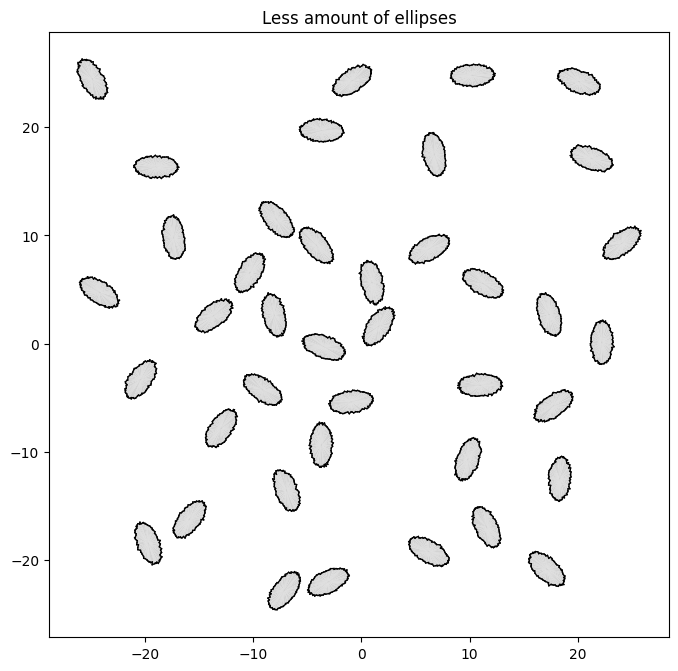

In [35]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

def rotate_points_about_center(points, center, angle):
    """
    Rotate an array of points about a specified center by 'angle' radians.
    """
    translated = points - center
    cosθ = math.cos(angle)
    sinθ = math.sin(angle)
    R = np.array([[cosθ, -sinθ], [sinθ, cosθ]])
    return translated.dot(R.T) + center

def generate_noisy_filled_ellipse(a, b, center, n_points, noise_std=0.0, seed=None):
    """
    Generates one filled ellipse (homeomorphic to D2) with semi-axes (a, b),
    discretized by n_points on the boundary plus the center, triangulated into
    2-simplices, randomly rotated, with optional Gaussian noise.
    Returns (points, simplices) where points is ((n_points+1)x2) and simplices
    is a list of 0-, 1-, and 2-simplices.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # 1) boundary vertices
    thetas = np.linspace(0, 2*math.pi, n_points, endpoint=False)
    xs = a * np.cos(thetas)
    ys = b * np.sin(thetas)
    boundary = np.vstack([xs, ys]).T + np.array(center)
    
    # 2) prepend the center as vertex 0
    pts = np.vstack([np.array(center).reshape(1,2), boundary])
    
    # 3) build simplices:
    simplices = []
    # 0-simplices
    for i in range(n_points+1):
        simplices.append([i])
    # 1-simplices: center-to-boundary spokes
    for i in range(1, n_points+1):
        simplices.append([0, i])
    # 1-simplices: boundary loop
    for i in range(1, n_points+1):
        simplices.append([i, (i % n_points) + 1])
    # 2-simplices: triangles (fan triangulation) [0, i, i+1]
    for i in range(1, n_points+1):
        simplices.append([0, i, (i % n_points) + 1])
    
    # 4) random rotation about the true center
    angle = np.random.uniform(0, 2*math.pi)
    pts = rotate_points_about_center(pts, np.array(center), angle)
    
    # 5) add noise to boundary only
    if noise_std > 0:
        noise = np.random.normal(scale=noise_std, size=pts.shape)
        noise[0] = 0.0
        pts += noise
    
    return pts, simplices

def sample_centers_square(side_length, n_centers, min_dist, seed=None, max_trials=10000):
    """
    Sample up to n_centers from a square region [-side/2, side/2]^2,
    enforcing a minimum distance between any two centers.
    """
    if seed is not None:
        np.random.seed(seed)
    half = side_length / 2.0
    centers = []
    trials = 0
    while len(centers) < n_centers and trials < max_trials:
        x = np.random.uniform(-half, half)
        y = np.random.uniform(-half, half)
        if all(math.hypot(x - cx, y - cy) >= min_dist for cx, cy in centers):
            centers.append((x, y))
        trials += 1
    if len(centers) < n_centers:
        raise RuntimeError(f"Only placed {len(centers)} out of {n_centers} centers.")
    return np.array(centers)

def generate_nonoverlapping_filled_ellipses_square(
    a, b, side_length,
    n_ellipses, n_points,
    noise_std=0.0, seed=None
):
    """
    Sample non-overlapping ellipse centers from a square region,
    then generate & merge filled ellipses into one simplicial complex.
    """
    # ensure bounding circles don't overlap
    min_dist = 2 * max(a, b)
    centers = sample_centers_square(side_length, n_ellipses, min_dist, seed)
    
    all_pts = []
    all_sims = []
    offset = 0
    for i, ctr in enumerate(centers):
        pts, sims = generate_noisy_filled_ellipse(
            a, b, ctr, n_points, noise_std,
            None if seed is None else seed + i
        )
        all_pts.append(pts)
        for s in sims:
            all_sims.append([idx + offset for idx in s])
        offset += pts.shape[0]
    
    return np.vstack(all_pts), all_sims, centers

def plot_filled_complex(points, simplices, centers=None, title='Filled Ellipses in Square'):
    """
    Plot the combined filled simplicial complex. Uses 2-simplices to fill shapes.
    """
    fig, ax = plt.subplots(figsize=(8,8))
    
    # collect all triangles for filling
    triangles = [points[s] for s in simplices if len(s) == 3]
    poly = PolyCollection(triangles,
                          facecolors='lightgray',
                          edgecolors='black',
                          linewidths=0.3,
                          alpha=1.0)
    ax.add_collection(poly)
    
    # optional: outline boundary edges
    for s in simplices:
        if len(s) == 2:
            pts_edge = points[s]
            ax.plot(pts_edge[:,0], pts_edge[:,1], 'k-', linewidth=0.5)
    
    # optional: mark centers
    if centers is not None:
        ax.scatter(centers[:,0], centers[:,1],
                   color='red', marker='x', s=40, label='centers')
        ax.legend()
    
    half = side_length / 2.0
    ax.set_xlim(-half - a, half + a)
    ax.set_ylim(-half - a, half + a)
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    plt.show()

# Example usage:
a, b = 2.0, 1.0
side_length = 50.0
n_ellipses = 40
n_points = 80
noise_std = 0.05
seed = 123

pts2, sims2, centers2 = generate_nonoverlapping_filled_ellipses_square(
    a, b, side_length,
    n_ellipses, n_points,
    noise_std, seed
)
def plot_filled_complex_boundary_only(points, simplices, centers=None, 
                                      n_points=None, title='Filled Ellipses'):
    """
    Plot the combined filled simplicial complex, but only show the outer
    boundary of each ellipse (no interior spokes or triangle edges).
    
    :param points:    (N×2) array of all vertices
    :param simplices: list of 0-, 1-, and 2-simplices
    :param centers:   (M×2) array of centers (optional, for plotting)
    :param n_points:  number of boundary points per ellipse (required if centers is given)
    """
    import matplotlib.pyplot as plt
    from matplotlib.collections import PolyCollection

    fig, ax = plt.subplots(figsize=(8,8))

    # 1) Fill all triangles with no edgelines
    triangles = [points[s] for s in simplices if len(s) == 3]
    poly = PolyCollection(triangles,
                          facecolors='lightgray',
                          edgecolors='none',    # <- no triangle edges
                          alpha=1.0)
    ax.add_collection(poly)

    # 2) Plot only the boundary loop edges of each ellipse.
    #    We know that in each ellipse the boundary 1-simplices are
    #    those [i, i+1] that do NOT involve a center index.
    boundary_edges = []
    center_indices = set()
    if centers is not None and n_points is not None:
        # center of ellipse j is at j*(n_points+1)
        # (since each filled ellipse has 1 center + n_points boundary vertices)
        for j in range(len(centers)):
            center_indices.add(j * (n_points + 1))

    for s in simplices:
        if len(s) == 2:
            i, j = s
            # skip any edge that involves a center
            if i in center_indices or j in center_indices:
                continue
            # otherwise this is a true boundary edge
            boundary_edges.append((i, j))

    for (i, j) in boundary_edges:
        xy = points[[i, j]]
        ax.plot(xy[:,0], xy[:,1], 'k-', linewidth=1)

    # 3) Optionally mark centers
    # if centers is not None:
    #     ax.scatter(centers[:,0], centers[:,1],
    #                c='red', marker='x', s=40, label='centers')
    #     ax.legend()

    ax.set_aspect('equal')
    ax.set_title(title)
    plt.show()
plot_filled_complex_boundary_only(pts2, sims2, centers2, n_points=n_points,
                                    title='Less amount of ellipses')

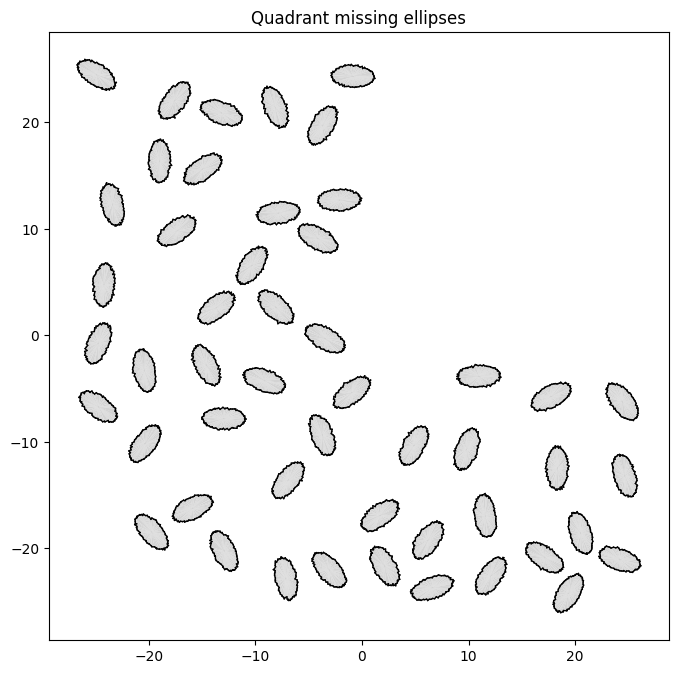

In [46]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

def rotate_points_about_center(points, center, angle):
    """
    Rotate an array of points about a specified center by 'angle' radians.
    """
    translated = points - center
    cosθ = math.cos(angle)
    sinθ = math.sin(angle)
    R = np.array([[cosθ, -sinθ], [sinθ, cosθ]])
    return translated.dot(R.T) + center

def generate_noisy_filled_ellipse(a, b, center, n_points, noise_std=0.0, seed=None):
    """
    Generates one filled ellipse (homeomorphic to D2) with semi-axes (a, b),
    discretized by n_points on the boundary plus the center, triangulated into
    2-simplices, randomly rotated, with optional Gaussian noise.
    Returns (points, simplices) where points is ((n_points+1)x2) and simplices
    is a list of 0-, 1-, and 2-simplices.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # 1) boundary vertices
    thetas = np.linspace(0, 2*math.pi, n_points, endpoint=False)
    xs = a * np.cos(thetas)
    ys = b * np.sin(thetas)
    boundary = np.vstack([xs, ys]).T + np.array(center)
    
    # 2) prepend the center as vertex 0
    pts = np.vstack([np.array(center).reshape(1,2), boundary])
    
    # 3) build simplices:
    simplices = []
    # 0-simplices
    for i in range(n_points+1):
        simplices.append([i])
    # 1-simplices: center-to-boundary spokes
    for i in range(1, n_points+1):
        simplices.append([0, i])
    # 1-simplices: boundary loop
    for i in range(1, n_points+1):
        simplices.append([i, (i % n_points) + 1])
    # 2-simplices: triangles (fan triangulation) [0, i, i+1]
    for i in range(1, n_points+1):
        simplices.append([0, i, (i % n_points) + 1])
    
    # 4) random rotation about the true center
    angle = np.random.uniform(0, 2*math.pi)
    pts = rotate_points_about_center(pts, np.array(center), angle)
    
    # 5) add noise to boundary only
    if noise_std > 0:
        noise = np.random.normal(scale=noise_std, size=pts.shape)
        noise[0] = 0.0
        pts += noise
    
    return pts, simplices

def sample_centers_square(side_length, n_centers, min_dist, seed=None, max_trials=10000):
    """
    Sample up to n_centers from a square region [-side/2, side/2]^2,
    enforcing a minimum distance between any two centers.
    """
    if seed is not None:
        np.random.seed(seed)
    half = side_length / 2.0
    centers = []
    trials = 0
    while len(centers) < n_centers and trials < max_trials:
        x = np.random.uniform(-half, half)
        y = np.random.uniform(-half, half)
        if all(math.hypot(x - cx, y - cy) >= min_dist for cx, cy in centers):
            centers.append((x, y))
        trials += 1
    if len(centers) < n_centers:
        raise RuntimeError(f"Only placed {len(centers)} out of {n_centers} centers.")
    return np.array(centers)

def generate_nonoverlapping_filled_ellipses_square_filtered(
    a, b, side_length,
    n_ellipses, n_points,
    noise_std=0.0, seed=None, max_trials=100000
):
    """
    Sample non-overlapping ellipse centers from a square region,
    *only* accepting those not in the first quadrant, until we have
    exactly n_ellipses. Then generate & merge the filled ellipses.
    """
    if seed is not None:
        np.random.seed(seed)
    half = side_length / 2.0
    min_dist = 2 * max(a, b)

    centers = []
    trials = 0
    while len(centers) < n_ellipses and trials < max_trials:
        # propose a center
        x = np.random.uniform(-half, half)
        y = np.random.uniform(-half, half)
        # skip first quadrant
        if x > 0 and y > 0:
            trials += 1
            continue
        # enforce non-overlap with already accepted
        if all(math.hypot(x - cx, y - cy) >= min_dist for cx, cy in centers):
            centers.append((x, y))
        trials += 1

    if len(centers) < n_ellipses:
        raise RuntimeError(f"Could only place {len(centers)} of {n_ellipses} ellipses outside the first quadrant.")

    centers = np.array(centers)

    # now generate the filled ellipses at these centers
    all_pts, all_sims = [], []
    offset = 0
    for i, ctr in enumerate(centers):
        pts, sims = generate_noisy_filled_ellipse(
            a, b, np.array(ctr), n_points, noise_std,
            None if seed is None else seed + i
        )
        all_pts.append(pts)
        for tri in sims:
            all_sims.append([idx + offset for idx in tri])
        offset += pts.shape[0]

    return np.vstack(all_pts), all_sims, centers


def plot_filled_complex(points, simplices, centers=None, title='Filtered Filled Ellipses'):
    fig, ax = plt.subplots(figsize=(8,8))
    # Fill triangles
    triangles = [points[t] for t in simplices]
    poly = PolyCollection(triangles, facecolors='lightgray', edgecolors='black', linewidths=0.3)
    ax.add_collection(poly)
    # Mark centers
    if centers is not None:
        ax.scatter(centers[:,0], centers[:,1], c='red', marker='x', s=40, label='centers')
        ax.legend()
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Example usage
a, b = 2.0, 1.0
side_length = 50.0
n_ellipses = 50
n_points = 80
noise_std = 0.05
seed = 123

pts_filt, sims_filt, centers_filt = generate_nonoverlapping_filled_ellipses_square_filtered(
    a, b, side_length, n_ellipses, n_points, noise_std, seed
)
def plot_filled_complex_boundary_only(points, simplices, centers=None, 
                                      n_points=None, title='Filled Ellipses'):
    """
    Plot the combined filled simplicial complex, but only show the outer
    boundary of each ellipse (no interior spokes or triangle edges).
    
    :param points:    (N×2) array of all vertices
    :param simplices: list of 0-, 1-, and 2-simplices
    :param centers:   (M×2) array of centers (optional, for plotting)
    :param n_points:  number of boundary points per ellipse (required if centers is given)
    """
    import matplotlib.pyplot as plt
    from matplotlib.collections import PolyCollection

    fig, ax = plt.subplots(figsize=(8,8))

    # 1) Fill all triangles with no edgelines
    triangles = [points[s] for s in simplices if len(s) == 3]
    poly = PolyCollection(triangles,
                          facecolors='lightgray',
                          edgecolors='none',    # <- no triangle edges
                          alpha=1.0)
    ax.add_collection(poly)

    # 2) Plot only the boundary loop edges of each ellipse.
    #    We know that in each ellipse the boundary 1-simplices are
    #    those [i, i+1] that do NOT involve a center index.
    boundary_edges = []
    center_indices = set()
    if centers is not None and n_points is not None:
        # center of ellipse j is at j*(n_points+1)
        # (since each filled ellipse has 1 center + n_points boundary vertices)
        for j in range(len(centers)):
            center_indices.add(j * (n_points + 1))

    for s in simplices:
        if len(s) == 2:
            i, j = s
            # skip any edge that involves a center
            if i in center_indices or j in center_indices:
                continue
            # otherwise this is a true boundary edge
            boundary_edges.append((i, j))

    for (i, j) in boundary_edges:
        xy = points[[i, j]]
        ax.plot(xy[:,0], xy[:,1], 'k-', linewidth=1)

    # 3) Optionally mark centers
    # if centers is not None:
    #     ax.scatter(centers[:,0], centers[:,1],
    #                c='red', marker='x', s=40, label='centers')
    #     ax.legend()

    ax.set_aspect('equal')
    ax.set_title(title)
    plt.show()
plot_filled_complex_boundary_only(pts_filt, sims_filt, centers_filt, n_points=n_points,
                                    title='Quadrant missing ellipses')

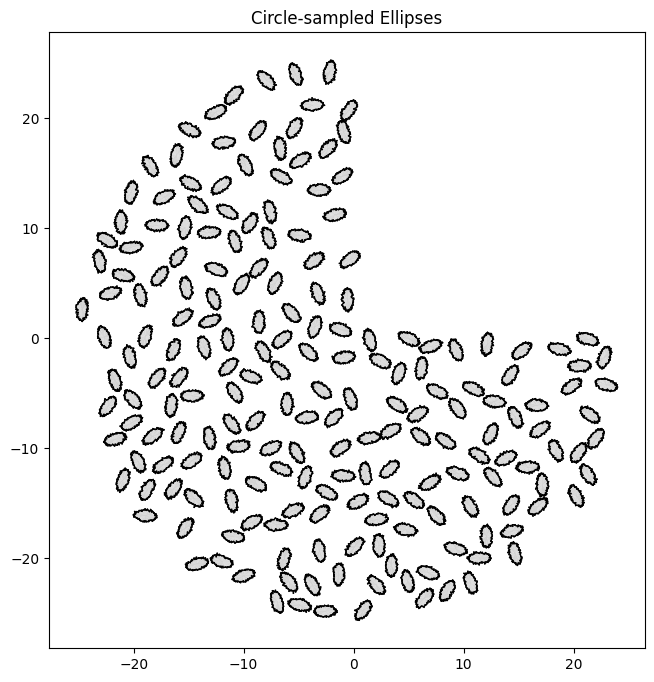

In [43]:
import numpy as np
import math

def sample_centers_circle(diameter, n_centers, min_dist, seed=None, max_trials=10000):
    """
    Sample up to n_centers uniformly from a disk of given diameter,
    enforcing a minimum distance between any two centers.
    """
    if seed is not None:
        np.random.seed(seed)
    radius = diameter / 2.0
    centers = []
    trials = 0
    while len(centers) < n_centers and trials < max_trials:
        # generate uniform point in disk via sqrt‐trick
        theta = np.random.uniform(0, 2*math.pi)
        r = radius * math.sqrt(np.random.uniform())
        x = r * math.cos(theta)
        y = r * math.sin(theta)
        # enforce min‐distance
        if all(math.hypot(x - cx, y - cy) >= min_dist for cx, cy in centers):
            centers.append((x, y))
        trials += 1

    if len(centers) < n_centers:
        raise RuntimeError(f"Only placed {len(centers)} out of {n_centers} centers.")
    return np.array(centers)


def generate_nonoverlapping_filled_ellipses_circle_filtered(
    a, b, diameter,
    n_ellipses, n_points,
    noise_std=0.0, seed=None, max_trials=100000
):
    """
    Sample non‐overlapping ellipse centers from a circular disk of given diameter,
    *only* accepting those not in the first quadrant, until we have exactly n_ellipses.
    Then generate & merge the filled ellipses.
    """
    if seed is not None:
        np.random.seed(seed)
    radius = diameter / 2.0
    min_dist = 2 * max(a, b)

    centers = []
    trials = 0
    while len(centers) < n_ellipses and trials < max_trials:
        # propose a center uniformly in the disk
        theta = np.random.uniform(0, 2*math.pi)
        r = radius * math.sqrt(np.random.uniform())
        x = r * math.cos(theta)
        y = r * math.sin(theta)

        # skip first quadrant
        if x > 0 and y > 0:
            trials += 1
            continue

        # enforce non‐overlap
        if all(math.hypot(x - cx, y - cy) >= min_dist for cx, cy in centers):
            centers.append((x, y))
        trials += 1

    if len(centers) < n_ellipses:
        raise RuntimeError(f"Could only place {len(centers)} of {n_ellipses} ellipses outside the first quadrant.")

    centers = np.array(centers)

    # generate the filled ellipses at these centers (same as before)...
    all_pts, all_sims = [], []
    offset = 0
    for i, ctr in enumerate(centers):
        pts, sims = generate_noisy_filled_ellipse(
            a, b, np.array(ctr), n_points, noise_std,
            None if seed is None else seed + i
        )
        all_pts.append(pts)
        for tri in sims:
            all_sims.append([idx + offset for idx in tri])
        offset += pts.shape[0]

    return np.vstack(all_pts), all_sims, centers

pts_filt, sims_filt, ctrs_filt = generate_nonoverlapping_filled_ellipses_circle_filtered(
    a=1.0, b=0.5, diameter=50.0,
    n_ellipses=200, n_points=80,
    noise_std=0.05, seed=123
)
plot_filled_complex_boundary_only(pts_filt, sims_filt, centers=ctrs_filt, n_points=80,
                                  title='Circle‐sampled Ellipses')



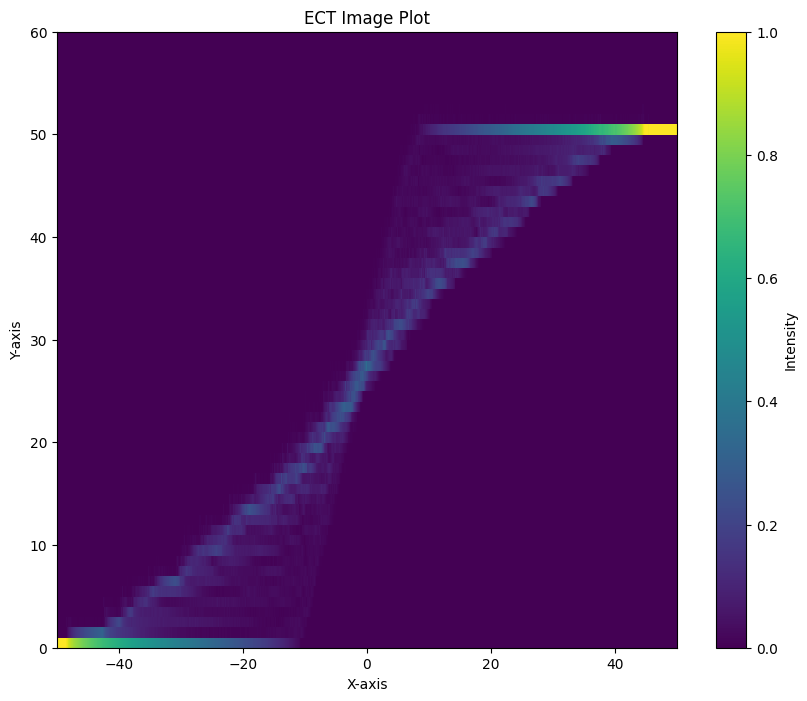

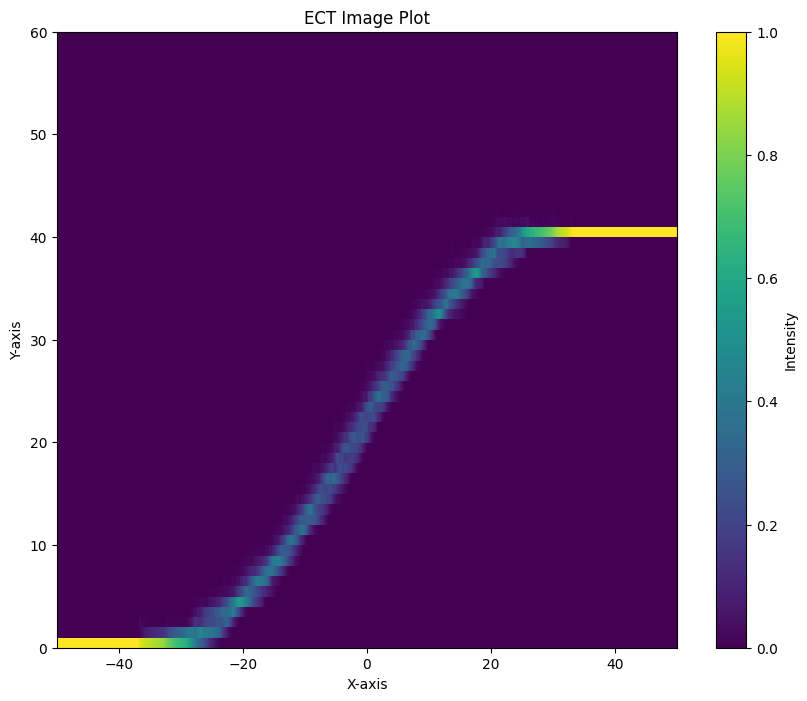

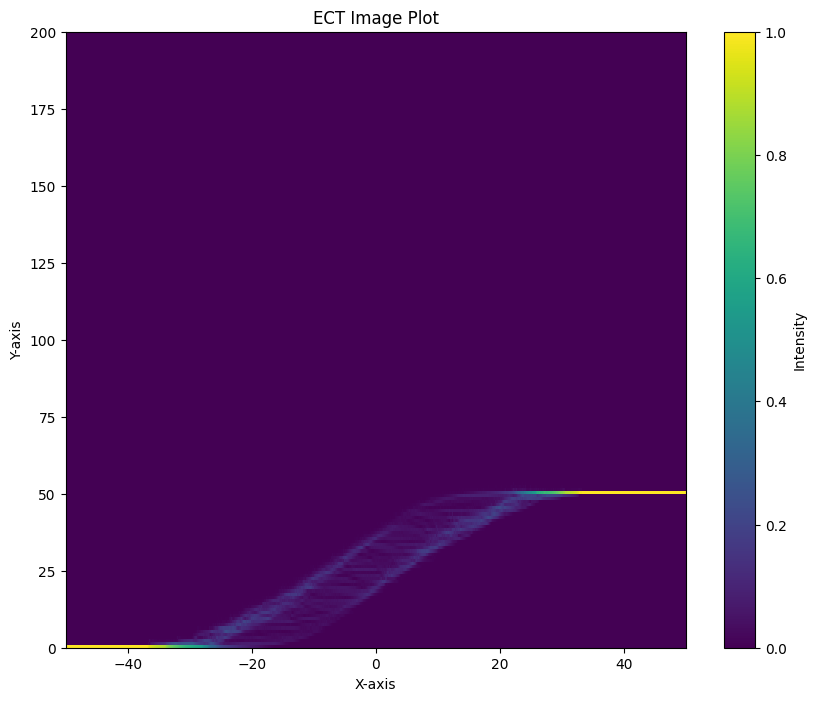

In [47]:
import My_ECT as detect
ect_image1 = detect.EctImg(sims1, pts1, k=1000, xinterval=(-50, 50), xpoints = 20000, yinterval=(0, 60), ypoints = 60)
ect_image2 = detect.EctImg(sims2, pts2, k=1000, xinterval=(-50, 50), xpoints = 20000, yinterval=(0, 60), ypoints = 60)
ect_image3 = detect.EctImg(sims_filt, pts_filt, k=1000, xinterval=(-50, 50), xpoints = 20000, yinterval=(0, 200), ypoints = 200)
ect_image1.plot()
ect_image2.plot()
ect_image3.plot()

In [48]:
import sys
sys.path.append('eucalc_directory')
import eucalc as ec
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import label, binary_fill_holes
import pickle

# Use the current directory for images.
datafolder = "."

# List all files with the .gif extension (case-insensitive)
all_files = os.listdir(datafolder)
names = [file for file in all_files if file.lower().endswith('.gif')]

# First pass: determine the maximum dimension among all images.
max_dim = 0
for file in names:
    file_path = os.path.join(datafolder, file)
    with Image.open(file_path) as img:
        width, height = img.size
        max_dim = max(max_dim, width, height)
target_length = max_dim + 10
print("Global target length for padding:", target_length)

# Group files by category and extract the number from each filename.
files_by_category = {}
for file in names:
    parts = file.split('-')
    if len(parts) < 2:
        continue
    category = parts[0]
    num_str = parts[1].split('.')[0]
    try:
        number = int(num_str)
    except ValueError:
        number = num_str
    files_by_category.setdefault(category, []).append((number, file))

for cat, file_list in files_by_category.items():
    file_list.sort(key=lambda x: x[0])
sorted_categories = sorted(files_by_category.keys())

# Parameters for the ECT computation.
k = 360*4
xinterval = (-1.5, 1.5)
xpoints = 3000

#--------------------------------------------------------------------------
def filter_to_largest_cc(img_array):
    mask   = img_array > 0
    filled = binary_fill_holes(mask)
    labeled, num = label(filled, structure=np.ones((3,3)))
    if num == 0:
        return np.zeros_like(img_array)
    sizes = np.bincount(labeled.ravel())
    if len(sizes) <= 1:
        return np.zeros_like(img_array)
    largest = np.argmax(sizes[1:]) + 1
    return (labeled == largest).astype(img_array.dtype)
#--------------------------------------------------------------------------

#--------------------------------------------------------------------------
def pad_image_to_square(img_array, target_length):
    h, w = img_array.shape
    white = np.argwhere(img_array > 0)
    if white.size == 0:
        centroid = np.array([h/2.0, w/2.0])
    else:
        centroid = white.mean(axis=0)
    center = np.array([target_length/2.0, target_length/2.0])
    offset = np.round(center - centroid).astype(int)

    new_img = np.zeros((target_length, target_length), dtype=img_array.dtype)
    pr, pc = offset
    dr0, dc0 = max(0, pr), max(0, pc)
    dr1 = min(target_length, pr + h)
    dc1 = min(target_length, pc + w)
    sr0, sc0 = max(0, -pr), max(0, -pc)
    sr1 = sr0 + (dr1 - dr0)
    sc1 = sc0 + (dc1 - dc0)

    new_img[dr0:dr1, dc0:dc1] = img_array[sr0:sr1, sc0:sc1]
    return new_img
#--------------------------------------------------------------------------

class EctImg:
    def __init__(self, nm, img, k=20, xinterval=(-1., 1.), xpoints=100):
        self.nm = nm
        self.xinterval = xinterval
        self.xpoints = xpoints
        self.image = self.compute(img, k, xinterval, xpoints)
    
    def compute(self, img, k, xinterval, xpoints):
        cplx = ec.EmbeddedComplex(img)
        cplx.preproc_ect()
        thetas = np.random.uniform(0, 2 * np.pi, k + 1)
        ect1 = np.empty((k, xpoints), dtype=float)
        for i in range(k):
            theta = thetas[i]
            direction = np.array((np.sin(theta), np.cos(theta)))
            ect_dir = cplx.compute_euler_characteristic_transform(direction)
            T = np.linspace(xinterval[0], xinterval[1], xpoints)
            ect1[i] = [ect_dir.evaluate(t) for t in T]
        return ect1

ECT_all     = []
labels_all  = []

for category in sorted_categories:
    for number, file in files_by_category[category]:
        fp = os.path.join(datafolder, file)
        with Image.open(fp) as img:
            try:
                img.seek(0)
            except EOFError:
                pass
            arr = np.array(img)
        if arr.ndim == 3:
            arr = arr.mean(axis=2).astype(arr.dtype)

        filtered = filter_to_largest_cc(arr)
        padded  = pad_image_to_square(filtered, target_length)
        ect_inst = EctImg(file, padded, k, xinterval, xpoints)
        ECT_all.append(ect_inst.image)
        labels_all.append((category, number))

# -------------------------------------------------------------------------
# SAVE EVERYTHING so you can reload later
# -------------------------------------------------------------------------
# as a single .npz (ECT_all and labels_all)
np.savez(
    "ECT_results.npz",
    ECT_all=ECT_all,
    labels_all=labels_all
)
print("Saved ECT_results.npz to", os.getcwd())


Global target length for padding: 1126
Saved ECT_results.npz to /Users/hyang/Desktop/MPEG-7_filled


## silverstone

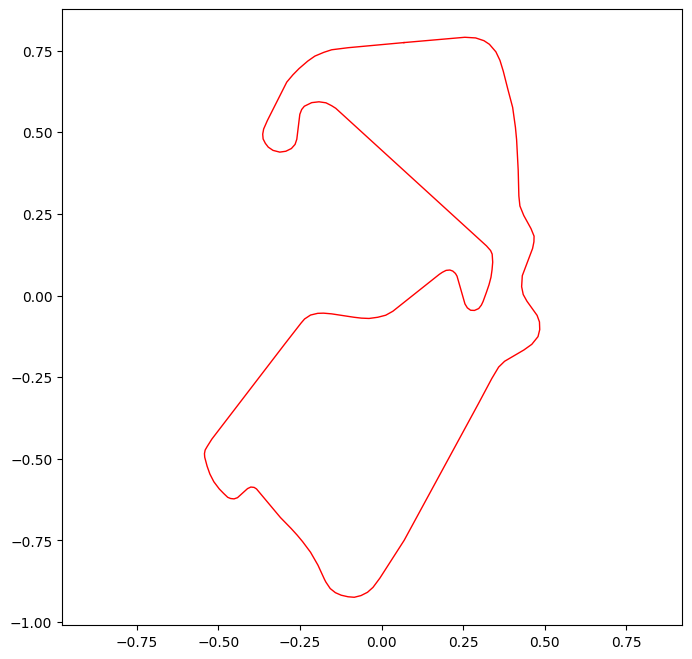

In [21]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Lat/lon coordinates
coords = np.array([
    (-1.015349, 52.07879), (-1.01262, 52.078936), (-1.012135, 52.078918), (-1.011762, 52.078842),
    (-1.011519, 52.078743), (-1.011229, 52.078536), (-1.011046, 52.0783), (-1.010898, 52.078003),
    (-1.01069, 52.077499), (-1.010477, 52.077004), (-1.010353, 52.076457), (-1.0103, 52.076113),
    (-1.010229, 52.075279), (-1.010199, 52.074567), (-1.010152, 52.074289), (-1.00998, 52.074029),
    (-1.009655, 52.073666), (-1.009518, 52.073459), (-1.009524, 52.073303), (-1.009584, 52.07312),
    (-1.010045, 52.07237), (-1.010075, 52.072068), (-1.010004, 52.071852), (-1.009838, 52.071668),
    (-1.009382, 52.071277), (-1.009276, 52.071097), (-1.009264, 52.070885), (-1.009341, 52.070692),
    (-1.009619, 52.07048), (-1.009974, 52.070324), (-1.01046, 52.07015), (-1.010838, 52.070013),
    (-1.011105, 52.069853), (-1.011412, 52.069537), (-1.012016, 52.06884), (-1.015337, 52.065083),
    (-1.016426, 52.064041), (-1.016734, 52.063786), (-1.016982, 52.06365), (-1.017272, 52.06356),
    (-1.017574, 52.063513), (-1.017852, 52.063527), (-1.01816, 52.06357), (-1.01842, 52.06364),
    (-1.018651, 52.063753), (-1.018847, 52.063933), (-1.018906, 52.064003), (-1.019202, 52.064399),
    (-1.019533, 52.064753), (-1.019888, 52.065045), (-1.020131, 52.065224), (-1.020403, 52.065408),
    (-1.020883, 52.06571), (-1.021954, 52.066497), (-1.022061, 52.066539), (-1.022209, 52.066549),
    (-1.022356, 52.066506), (-1.022806, 52.066256), (-1.02296, 52.066223), (-1.023114, 52.066233),
    (-1.023244, 52.066266), (-1.023428, 52.066374), (-1.023623, 52.066497), (-1.023866, 52.066695),
    (-1.024043, 52.066907), (-1.024168, 52.067124), (-1.024274, 52.067369), (-1.024286, 52.067468),
    (-1.024256, 52.067567), (-1.024168, 52.067661), (-1.023955, 52.067869), (-1.020687, 52.070489),
    (-1.019953, 52.071069), (-1.0198, 52.071178), (-1.019533, 52.071286), (-1.019214, 52.071333),
    (-1.018953, 52.071338), (-1.018592, 52.071319), (-1.017586, 52.071225), (-1.017254, 52.071201),
    (-1.016911, 52.071192), (-1.01652, 52.071225), (-1.016165, 52.071281), (-1.015846, 52.07139),
    (-1.013762, 52.072408), (-1.013626, 52.072464), (-1.01346, 52.072516), (-1.013289, 52.072526),
    (-1.013159, 52.072497), (-1.01304, 52.072431), (-1.012969, 52.072356), (-1.012614, 52.071592),
    (-1.012507, 52.071484), (-1.01236, 52.071418), (-1.012188, 52.071413), (-1.011998, 52.071465),
    (-1.01188, 52.071559), (-1.011803, 52.071658), (-1.011655, 52.071908), (-1.011537, 52.07212),
    (-1.011448, 52.072328), (-1.011401, 52.07253), (-1.011371, 52.072743), (-1.011395, 52.072964),
    (-1.011466, 52.073063), (-1.011649, 52.07319), (-1.018403, 52.07698), (-1.018586, 52.077051),
    (-1.018841, 52.077131), (-1.019154, 52.077159), (-1.01948, 52.077136), (-1.019811, 52.077037),
    (-1.01993, 52.076947), (-1.020013, 52.076815), (-1.020149, 52.076127), (-1.020226, 52.075986),
    (-1.020391, 52.075872), (-1.02064, 52.075797), (-1.020912, 52.075773), (-1.021214, 52.075821),
    (-1.021427, 52.07591), (-1.021557, 52.076014), (-1.021658, 52.076136), (-1.021676, 52.076268),
    (-1.021634, 52.07641), (-1.021469, 52.076641), (-1.020599, 52.077701), (-1.02032, 52.077904),
    (-1.020048, 52.078074), (-1.019657, 52.078281), (-1.019338, 52.078418), (-1.018935, 52.078522),
    (-1.018586, 52.078592), (-1.017846, 52.078649), (-1.015349, 52.07879)
])

# Projection to km
lon0, lat0 = coords.mean(axis=0)
lat0_rad = math.radians(lat0)
R = 6371
dlat = np.radians(coords[:,1] - lat0)
dlon = np.radians(coords[:,0] - lon0)
x_km = R * dlon * np.cos(lat0_rad)
y_km = R * dlat

# Centering
x_c = x_km - x_km.mean()
y_c = y_km - y_km.mean()

# Plot with truly equal scaling
plt.figure(figsize=(8,8))
plt.plot(x_c, y_c, '-r', linewidth=1,)
plt.axis('equal')  # Ensures unit length on x and y are the same

plt.show()


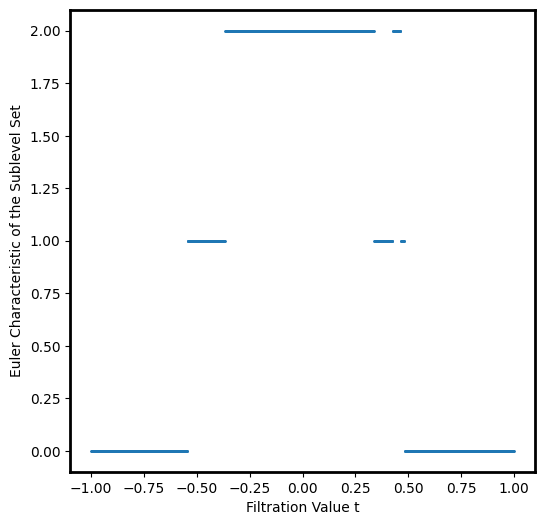

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.


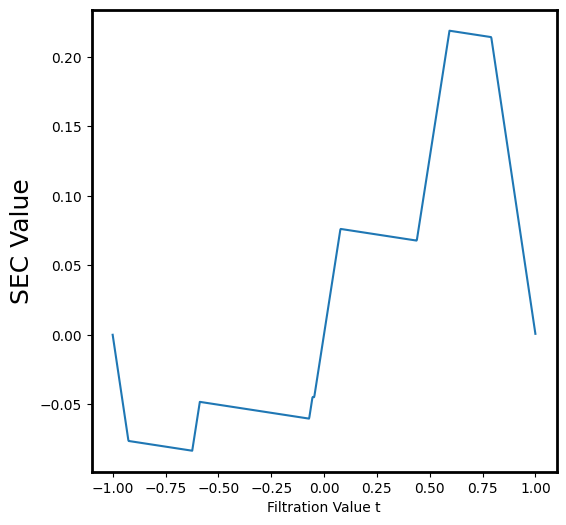

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.


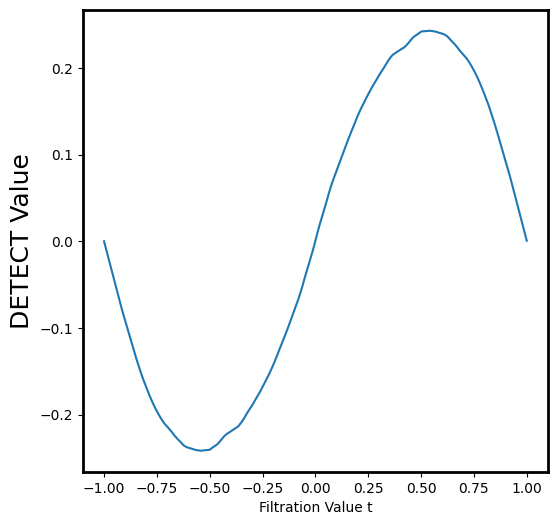

In [20]:
import numpy as np
import math
import numba as nb
import matplotlib.pyplot as plt

import My_ECT as detect

# Silverstone Circuit coordinates (1948 layout)
latlon = np.array([
    (-1.015349, 52.07879), (-1.01262, 52.078936), (-1.012135, 52.078918), (-1.011762, 52.078842),
    (-1.011519, 52.078743), (-1.011229, 52.078536), (-1.011046, 52.0783), (-1.010898, 52.078003),
    (-1.01069, 52.077499), (-1.010477, 52.077004), (-1.010353, 52.076457), (-1.0103, 52.076113),
    (-1.010229, 52.075279), (-1.010199, 52.074567), (-1.010152, 52.074289), (-1.00998, 52.074029),
    (-1.009655, 52.073666), (-1.009518, 52.073459), (-1.009524, 52.073303), (-1.009584, 52.07312),
    (-1.010045, 52.07237), (-1.010075, 52.072068), (-1.010004, 52.071852), (-1.009838, 52.071668),
    (-1.009382, 52.071277), (-1.009276, 52.071097), (-1.009264, 52.070885), (-1.009341, 52.070692),
    (-1.009619, 52.07048), (-1.009974, 52.070324), (-1.01046, 52.07015), (-1.010838, 52.070013),
    (-1.011105, 52.069853), (-1.011412, 52.069537), (-1.012016, 52.06884), (-1.015337, 52.065083),
    (-1.016426, 52.064041), (-1.016734, 52.063786), (-1.016982, 52.06365), (-1.017272, 52.06356),
    (-1.017574, 52.063513), (-1.017852, 52.063527), (-1.01816, 52.06357), (-1.01842, 52.06364),
    (-1.018651, 52.063753), (-1.018847, 52.063933), (-1.018906, 52.064003), (-1.019202, 52.064399),
    (-1.019533, 52.064753), (-1.019888, 52.065045), (-1.020131, 52.065224), (-1.020403, 52.065408),
    (-1.020883, 52.06571), (-1.021954, 52.066497), (-1.022061, 52.066539), (-1.022209, 52.066549),
    (-1.022356, 52.066506), (-1.022806, 52.066256), (-1.02296, 52.066223), (-1.023114, 52.066233),
    (-1.023244, 52.066266), (-1.023428, 52.066374), (-1.023623, 52.066497), (-1.023866, 52.066695),
    (-1.024043, 52.066907), (-1.024168, 52.067124), (-1.024274, 52.067369), (-1.024286, 52.067468),
    (-1.024256, 52.067567), (-1.024168, 52.067661), (-1.023955, 52.067869), (-1.020687, 52.070489),
    (-1.019953, 52.071069), (-1.0198, 52.071178), (-1.019533, 52.071286), (-1.019214, 52.071333),
    (-1.018953, 52.071338), (-1.018592, 52.071319), (-1.017586, 52.071225), (-1.017254, 52.071201),
    (-1.016911, 52.071192), (-1.01652, 52.071225), (-1.016165, 52.071281), (-1.015846, 52.07139),
    (-1.013762, 52.072408), (-1.013626, 52.072464), (-1.01346, 52.072516), (-1.013289, 52.072526),
    (-1.013159, 52.072497), (-1.01304, 52.072431), (-1.012969, 52.072356), (-1.012614, 52.071592),
    (-1.012507, 52.071484), (-1.01236, 52.071418), (-1.012188, 52.071413), (-1.011998, 52.071465),
    (-1.01188, 52.071559), (-1.011803, 52.071658), (-1.011655, 52.071908), (-1.011537, 52.07212),
    (-1.011448, 52.072328), (-1.011401, 52.07253), (-1.011371, 52.072743), (-1.011395, 52.072964),
    (-1.011466, 52.073063), (-1.011649, 52.07319), (-1.018403, 52.07698), (-1.018586, 52.077051),
    (-1.018841, 52.077131), (-1.019154, 52.077159), (-1.01948, 52.077136), (-1.019811, 52.077037),
    (-1.01993, 52.076947), (-1.020013, 52.076815), (-1.020149, 52.076127), (-1.020226, 52.075986),
    (-1.020391, 52.075872), (-1.02064, 52.075797), (-1.020912, 52.075773), (-1.021214, 52.075821),
    (-1.021427, 52.07591), (-1.021557, 52.076014), (-1.021658, 52.076136), (-1.021676, 52.076268),
    (-1.021634, 52.07641), (-1.021469, 52.076641), (-1.020599, 52.077701), (-1.02032, 52.077904),
    (-1.020048, 52.078074), (-1.019657, 52.078281), (-1.019338, 52.078418), (-1.018935, 52.078522),
    (-1.018586, 52.078592), (-1.017846, 52.078649), (-1.015349, 52.07879)
])

# Compute local Cartesian coordinates (km) and center them
lon0, lat0 = latlon.mean(axis=0)
lat0_rad = math.radians(lat0)
R = 6371.0  # Earth radius in km

dlat = np.radians(latlon[:,1] - lat0)
dlon = np.radians(latlon[:,0] - lon0)
x_km = R * dlon * np.cos(lat0_rad)
y_km = R * dlat

# Center so sum of coordinates = (0,0)
x = x_km - x_km.mean()
y = y_km - y_km.mean()

# Combine into points array
points = np.vstack((x, y)).T
n_points = points.shape[0]

# Build simplicial complex (0- and 1-simplices)
simplices = []
for i in range(n_points):
    simplices.append([i])
    simplices.append([i, (i+1) % n_points])  # edge to next, closing loop automatically

# Convert simplices to numba-friendly typed list
numba_test_shape = nb.typed.List()
for s in simplices:
    numba_test_shape.append(nb.typed.List(s))
ect_curves = []
sect_curves = []
detect_curves = []
ect_result = detect.euler_curve(numba_test_shape, points, np.array((1., 0.)), interval=(-1., 1.), points=1000)
ect_curves.append(ect_result)
sect_result = detect.cumulative_euler_curve(numba_test_shape, points, np.array((np.cos(np.pi/2), np.sin(np.pi/2))), interval=(-1., 1.), points=1000)
sect_curves.append(sect_result)
detect_result = detect.sect_2d(numba_test_shape, points, k=20, interval=(-1., 1.), points=1000, mode='mean')
detect_curves.append(detect_result)

x_values = np.linspace(-1, 1, 1000)


# Plotting ECC curves
plt.figure(figsize=(6, 6))
for i, curve in enumerate(ect_curves):
    for x1, y1, x2, y2 in zip(x_values[:-1], curve[:-1], x_values[1:], curve[1:]):
        if y1 == y2:
            plt.plot([x1, x2], [y1, y2], color='C{}'.format(i), linewidth=1)  # 'C{}'.format(i) cycles through default colors
    plt.scatter(x_values, curve, label=f'ECC curve', s=1)
plt.xlabel('Filtration Value t')
plt.ylabel('Euler Characteristic of the Sublevel Set')


# Adjusting the border thickness
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Adjust the linewidth as needed

plt.show()

# Plotting SEC curves
plt.figure(figsize=(6, 6))
for i, curve in enumerate(sect_curves):
    plt.plot(x_values, curve, label=f'SEC')
plt.xlabel('Filtration Value t')
plt.ylabel('SEC Value', fontsize=18, fontname='Palatino Linotype')


ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Adjust the linewidth as needed

plt.show()

# Plotting DETECT curves
plt.figure(figsize=(6, 6))
for i, curve in enumerate(detect_curves):
    plt.plot(x_values, curve, label=f'DETECT')

plt.xlabel('Filtration Value t')
plt.ylabel('DETECT Value', fontsize=18, fontname='Palatino Linotype')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Adjust the linewidth as needed

plt.show()

